# Knowledge Distillation

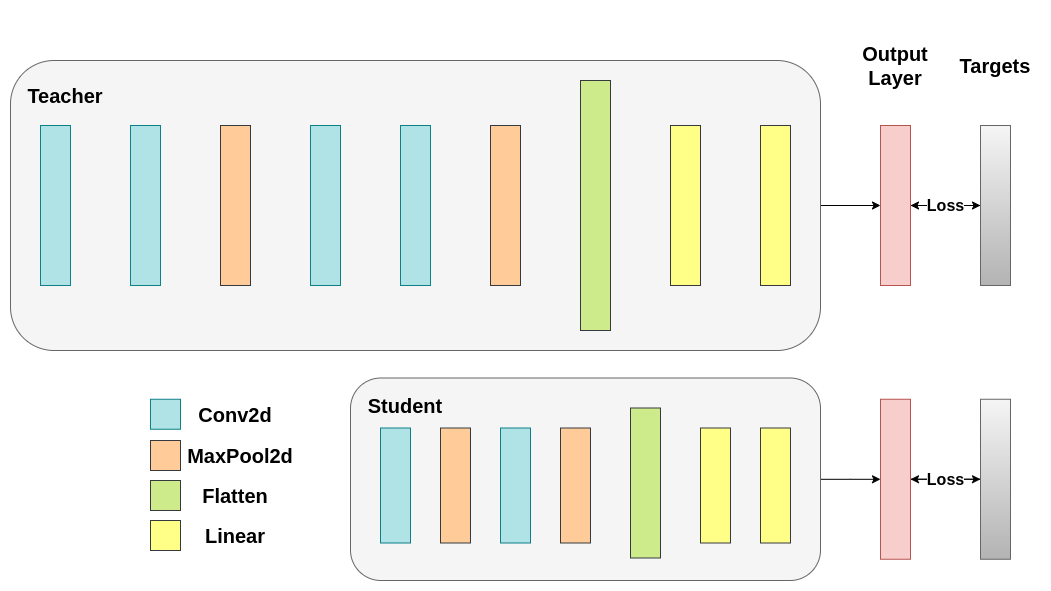

In [1]:
!pip install efficientnet-pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from PIL import Image, ImageOps, ImageEnhance
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## Load in pretrained effnet model and remove its head, replacing it with fully connected layer
## that gives 10 outputs
def get_model(model_name='efficientnet-b0'):
    model = EfficientNet.from_pretrained(model_name)
    del model._fc
    # # # use the same head as the baseline notebook.
    model._fc = nn.Linear(1280, 10)
    return model

# Teacher model

In [4]:
teacher = get_model()
teacher.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\khusl/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [01:05<00:00, 325kB/s]

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [5]:
dummy_input = torch.rand(16,3,32,32).to(device)

In [6]:
out = teacher(dummy_input)

# MNIST DATASET

In [7]:
train_data = datasets.MNIST('./', train=True, transform=transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),transforms.Resize(32), transforms.ToTensor()]
    ), download=True)
test_data = datasets.MNIST('./', train=False, transform=transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),transforms.Resize(32), transforms.ToTensor()]
    ), download=True)

In [8]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle=True)

In [10]:
for x,y in train_dl:
  out = teacher(x.to(device))
  print(x.shape, y.shape, out.argmax(dim=1).shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64]) torch.Size([64])


# Teacher training

In [11]:
# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [12]:
# make directorch to save dataset
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [13]:
# set hyper parameters
# define the training parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [14]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/29, current lr= 0.001
Copied best model weights!
train loss: 0.002588, val loss: 0.000468, accuracy: 98.44, time: 1.1037 min
----------
Epoch 1/29, current lr= 0.001
Copied best model weights!
train loss: 0.000942, val loss: 0.000313, accuracy: 98.91, time: 2.1767 min
----------
Epoch 2/29, current lr= 0.001
train loss: 0.000753, val loss: 0.000326, accuracy: 98.76, time: 3.2300 min
----------
Epoch 3/29, current lr= 0.001
train loss: 0.000739, val loss: 0.000396, accuracy: 98.64, time: 4.3067 min
----------
Epoch 4/29, current lr= 0.001
train loss: 0.000477, val loss: 0.000331, accuracy: 98.82, time: 5.3773 min
----------
Epoch 5/29, current lr= 0.001
Copied best model weights!
train loss: 0.000596, val loss: 0.000296, accuracy: 99.07, time: 6.4335 min
----------
Epoch 6/29, current lr= 0.001
Copied best model weights!
train loss: 0.000529, val loss: 0.000199, accuracy: 99.26, time: 7.4978 min
----------
Epoch 7/29, current lr= 0.001
train loss: 0.000385, val loss: 0.000234, a

Teacher accuracy = 99.39\%

Loss = 0.000162

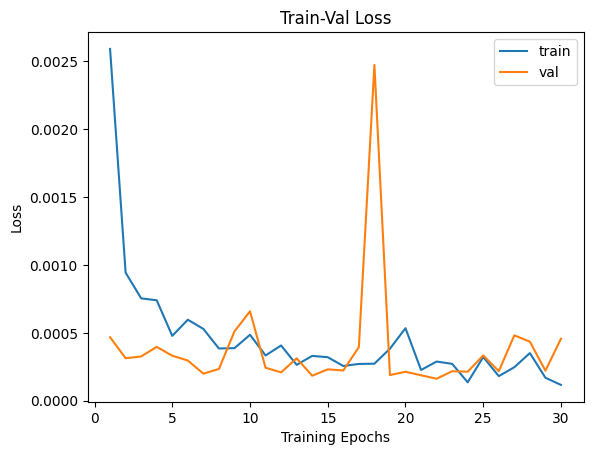

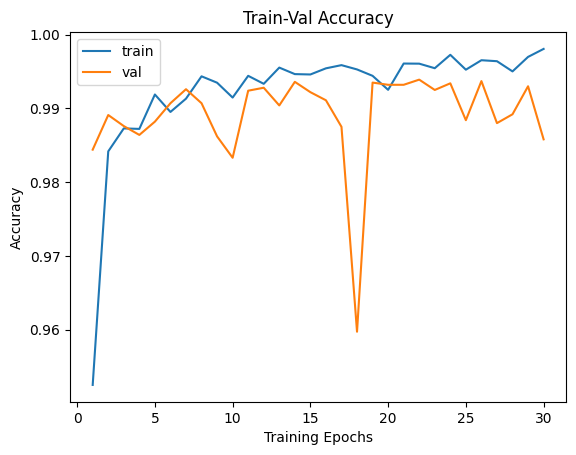

In [15]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# Student Training

In [30]:
class student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x[:,0,:,:]
        x = x.view(-1, 32*32)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [31]:
# check
x = torch.randn(16,3,32,32).to(device)
Student = student().to(device)
output = Student(x)
print(output.shape)

torch.Size([16, 10])


In [32]:
Teacher = get_model().to(device)
# load weight
Teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))

Student = student().to(device)

Loaded pretrained weights for efficientnet-b0


In [33]:
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(Student.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [36]:
# set hyper parameters
# define the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/student_weights.pt',
}


In [37]:
Student, loss_hist, metric_hist = train_val(Student, params_train)

Epoch 0/9, current lr= 0.001
Copied best model weights!
train loss: 0.001800, val loss: 0.000666, accuracy: 97.48, time: 0.3941 min
----------
Epoch 1/9, current lr= 0.001
Copied best model weights!
train loss: 0.001140, val loss: 0.000531, accuracy: 97.87, time: 0.7898 min
----------
Epoch 2/9, current lr= 0.001
train loss: 0.000875, val loss: 0.000615, accuracy: 97.73, time: 1.1614 min
----------
Epoch 3/9, current lr= 0.001
Copied best model weights!
train loss: 0.000721, val loss: 0.000502, accuracy: 97.97, time: 1.5864 min
----------
Epoch 4/9, current lr= 0.001
train loss: 0.000581, val loss: 0.000549, accuracy: 98.07, time: 1.9723 min
----------
Epoch 5/9, current lr= 0.001
Copied best model weights!
train loss: 0.000528, val loss: 0.000427, accuracy: 98.35, time: 2.3581 min
----------
Epoch 6/9, current lr= 0.001
train loss: 0.000427, val loss: 0.000542, accuracy: 98.18, time: 2.7334 min
----------
Epoch 7/9, current lr= 0.001
train loss: 0.000383, val loss: 0.000476, accuracy:

Student accuracy = 98.35\%

Loss = 0.000427

# Knowledge Distillation

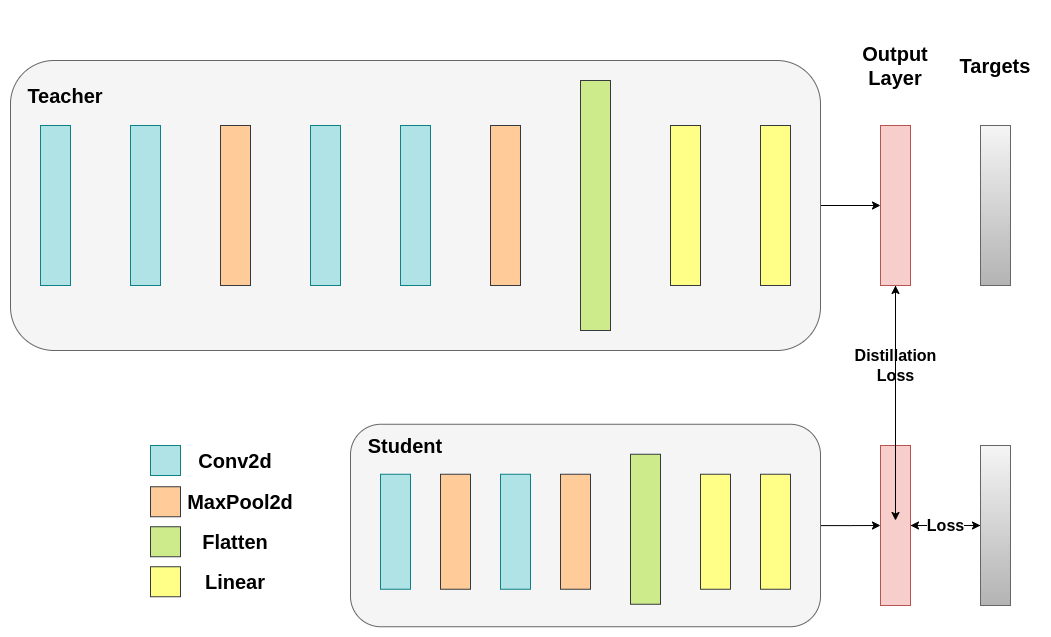

In [39]:
# optimizer
opt = optim.Adam(Student.parameters())

# distillation
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [40]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

In [44]:
num_epochs= 30

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    Student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = Student(xb)
        teacher_output = Teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    Student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(Student, loss_func, test_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/29, current lr= 0.001


<ipython-input-39-6254c49df788>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
<ipython-input-39-6254c49df788>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train loss: 0.036665, val loss: 0.001082, accuracy: 97.40, time: 0.7074 min
----------
Epoch 1/29, current lr= 0.001
train loss: 0.032863, val loss: 0.001103, accuracy: 97.71, time: 1.4014 min
----------
Epoch 2/29, current lr= 0.001
train loss: 0.030048, val loss: 0.000872, accuracy: 98.04, time: 2.1010 min
----------
Epoch 3/29, current lr= 0.001
train loss: 0.028253, val loss: 0.000764, accuracy: 98.15, time: 2.7945 min
----------
Epoch 4/29, current lr= 0.001
train loss: 0.027595, val loss: 0.000640, accuracy: 98.27, time: 3.4885 min
----------
Epoch 5/29, current lr= 0.001
train loss: 0.026455, val loss: 0.000677, accuracy: 98.18, time: 4.1883 min
----------
Epoch 6/29, current lr= 0.001
train loss: 0.025896, val loss: 0.000569, accuracy: 98.38, time: 4.8823 min
----------
Epoch 7/29, current lr= 0.001
train loss: 0.024808, val loss: 0.000549, accuracy: 98.60, time: 5.5797 min
----------
Epoch 8/29, current lr= 0.001
train loss: 0.024494, val loss: 0.000541, accuracy: 98.42, time:

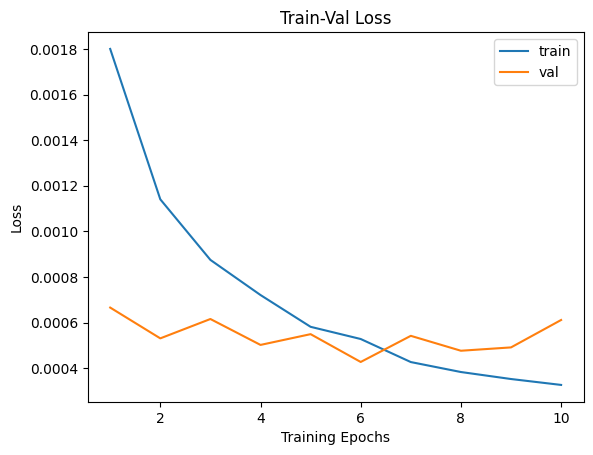

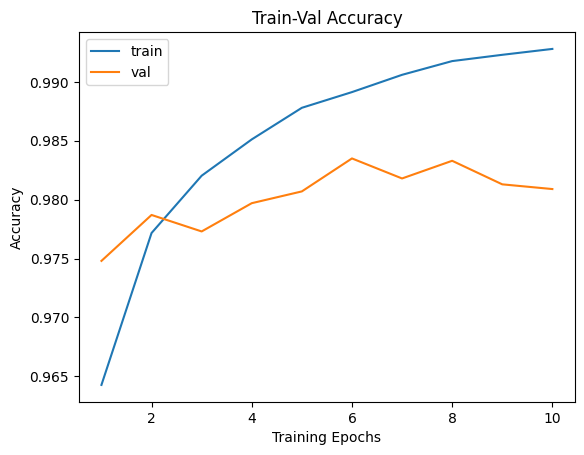

In [45]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

Taught Student accuracy: 98.79

Loss : 0.000427

# Даалгавар: Teacher болон Student загварын дундаас нь мэдлэгийг дамжуулах замаар сургалтыг гүйцэтгэн үр дүнг лабораторийн үр дүнтэй харьцуул

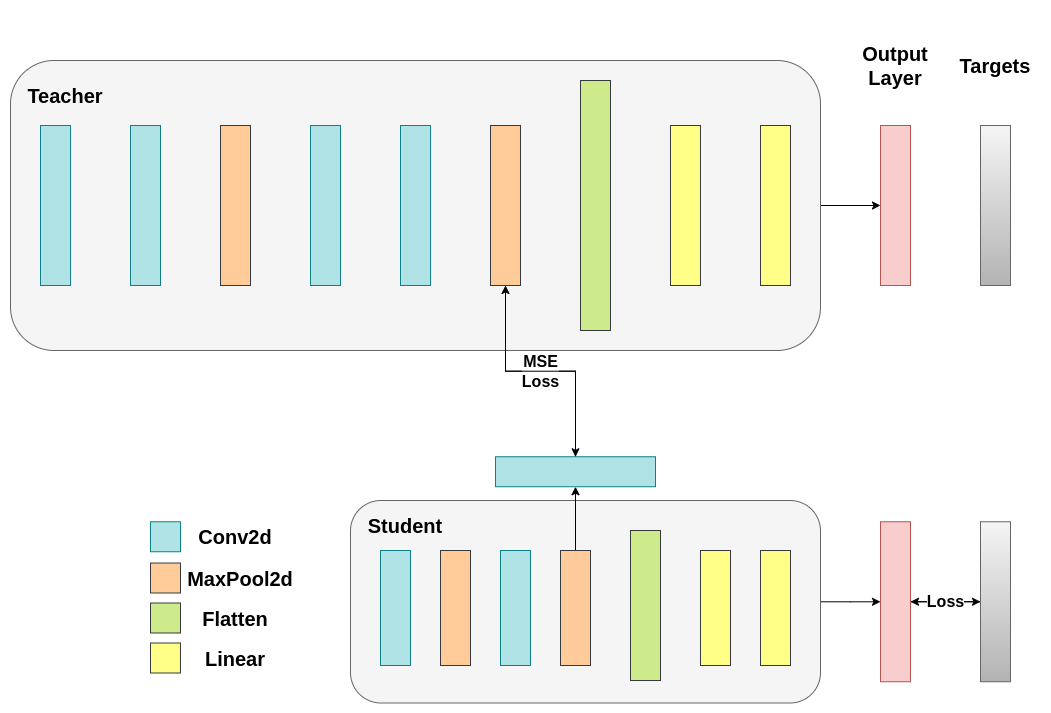